In [3]:
#Importing libraries
import pandas as pd
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
import sdt.changepoint as c
import math

In [4]:
#import ARIMA libraries
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np

In [5]:
# create a dataframe from the csv file
df_new_cases = pd.read_csv('../data/WHO-COVID-19-global-data.csv')
#df_vaccination = pd.read_csv('../data/owid-covid-data.csv')
df_vaccination = pd.read_csv('../data/country_vaccinations.csv')

In [6]:
# add moving average for new cases
#df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['new_vaccinations'].transform(lambda x: x.rolling(window=7).mean()) # OWID
df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['daily_vaccinations'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_vaccination = df_vaccination.dropna(subset=['moving_average_new_vaccinations'])
df_vaccination = df_vaccination[df_vaccination['moving_average_new_vaccinations'] != 0.0]

In [7]:
# add moving average for new cases
df_new_cases['moving_average_new_cases'] = df_new_cases.groupby('Country_code')['New_cases'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_new_cases = df_new_cases.dropna(subset=['moving_average_new_cases'])
df_new_cases = df_new_cases[df_new_cases['moving_average_new_cases'] != 0.0]

In [8]:
# firter data from 2021-07-16 to 2021-08-15
start_date = date(2021, 1, 1) 
og_start_date = date(2021, 7, 22)
og_end_date = date(2021, 8, 9)
end_date = date(2021, 8, 31)

difference = og_start_date - start_date
event_duration = og_end_date - og_start_date

# filter df_vaccination and df_new_cases from 2020-12-08 to 2021-08-31
start_vaccination = date(2020, 12, 8)
end_study = date(2021, 8, 31)
df_vaccination = df_vaccination[(df_vaccination['date'] >= str(start_vaccination)) & (df_vaccination['date'] <= str(end_study))]
df_vaccination = df_vaccination.reset_index(drop=True)
df_new_cases = df_new_cases[(df_new_cases['Date_reported'] >= str(start_vaccination)) & (df_new_cases['Date_reported'] <= str(end_study))]
df_new_cases = df_new_cases.reset_index(drop=True)

In [9]:
#filter by iso_cod that not contain "OWID" prefix
df_vaccination = df_vaccination[~df_vaccination['iso_code'].str.contains("OWID")]

# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
#df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'people_vaccinated':'sum', 'new_vaccinations': 'sum', 'location': 'max', 'moving_average_new_vaccinations': 'sum'})
df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'total_vaccinations':'sum', 'daily_vaccinations': 'sum', 'country': 'max', 'moving_average_new_vaccinations': 'sum'})

In [10]:
#aggiungi alla riga attuale nella colonna iso_code il valore iso
convert_ISO_3166_2_to_1 = {
    'AF':'AFG',
    'AX':'ALA',
    'AL':'ALB',
    'DZ':'DZA',
    'AS':'ASM',
    'AD':'AND',
    'AO':'AGO',
    'AI':'AIA',
    'AQ':'ATA',
    'AG':'ATG',
    'AR':'ARG',
    'AM':'ARM',
    'AW':'ABW',
    'AU':'AUS',
    'AT':'AUT',
    'AZ':'AZE',
    'BS':'BHS',
    'BH':'BHR',
    'BD':'BGD',
    'BB':'BRB',
    'BY':'BLR',
    'BE':'BEL',
    'BZ':'BLZ',
    'BJ':'BEN',
    'BM':'BMU',
    'BT':'BTN',
    'BO':'BOL',
    'BA':'BIH',
    'BW':'BWA',
    'BV':'BVT',
    'BR':'BRA',
    'IO':'IOT',
    'BN':'BRN',
    'BG':'BGR',
    'BF':'BFA',
    'BI':'BDI',
    'KH':'KHM',
    'CM':'CMR',
    'CA':'CAN',
    'CV':'CPV',
    'KY':'CYM',
    'CF':'CAF',
    'TD':'TCD',
    'CL':'CHL',
    'CN':'CHN',
    'CX':'CXR',
    'CC':'CCK',
    'CO':'COL',
    'KM':'COM',
    'CG':'COG',
    'CD':'COD',
    'CK':'COK',
    'CR':'CRI',
    'CI':'CIV',
    'HR':'HRV',
    'CU':'CUB',
    'CY':'CYP',
    'CZ':'CZE',
    'DK':'DNK',
    'DJ':'DJI',
    'DM':'DMA',
    'DO':'DOM',
    'EC':'ECU',
    'EG':'EGY',
    'SV':'SLV',
    'GQ':'GNQ',
    'ER':'ERI',
    'EE':'EST',
    'ET':'ETH',
    'FK':'FLK',
    'FO':'FRO',
    'FJ':'FJI',
    'FI':'FIN',
    'FR':'FRA',
    'GF':'GUF',
    'PF':'PYF',
    'TF':'ATF',
    'GA':'GAB',
    'GM':'GMB',
    'GE':'GEO',
    'DE':'DEU',
    'GH':'GHA',
    'GI':'GIB',
    'GR':'GRC',
    'GL':'GRL',
    'GD':'GRD',
    'GP':'GLP',
    'GU':'GUM',
    'GT':'GTM',
    'GG':'GGY',
    'GN':'GIN',
    'GW':'GNB',
    'GY':'GUY',
    'HT':'HTI',
    'HM':'HMD',
    'VA':'VAT',
    'HN':'HND',
    'HK':'HKG',
    'HU':'HUN',
    'IS':'ISL',
    'IN':'IND',
    'ID':'IDN',
    'IR':'IRN',
    'IQ':'IRQ',
    'IE':'IRL',
    'IM':'IMN',
    'IL':'ISR',
    'IT':'ITA',
    'JM':'JAM',
    'JP':'JPN',
    'JE':'JEY',
    'JO':'JOR',
    'KZ':'KAZ',
    'KE':'KEN',
    'KI':'KIR',
    'KP':'PRK',
    'KR':'KOR',
    'KW':'KWT',
    'KG':'KGZ',
    'LA':'LAO',
    'LV':'LVA',
    'LB':'LBN',
    'LS':'LSO',
    'LR':'LBR',
    'LY':'LBY',
    'LI':'LIE',
    'LT':'LTU',
    'LU':'LUX',
    'MO':'MAC',
    'MK':'MKD',
    'MG':'MDG',
    'MW':'MWI',
    'MY':'MYS',
    'MV':'MDV',
    'ML':'MLI',
    'MT':'MLT',
    'MH':'MHL',
    'MQ':'MTQ',
    'MR':'MRT',
    'MU':'MUS',
    'YT':'MYT',
    'MX':'MEX',
    'FM':'FSM',
    'MD':'MDA',
    'MC':'MCO',
    'MN':'MNG',
    'ME':'MNE',
    'MS':'MSR',
    'MA':'MAR',
    'MZ':'MOZ',
    'MM':'MMR',
    'NA':'NAM',
    'NR':'NRU',
    'NP':'NPL',
    'NL':'NLD',
    'AN':'ANT',
    'NC':'NCL',
    'NZ':'NZL',
    'NI':'NIC',
    'NE':'NER',
    'NG':'NGA',
    'NU':'NIU',
    'NF':'NFK',
    'MP':'MNP',
    'NO':'NOR',
    'OM':'OMN',
    'PK':'PAK',
    'PW':'PLW',
    'PS':'PSE',
    'PA':'PAN',
    'PG':'PNG',
    'PY':'PRY',
    'PE':'PER',
    'PH':'PHL',
    'PN':'PCN',
    'PL':'POL',
    'PT':'PRT',
    'PR':'PRI',
    'QA':'QAT',
    'RE':'REU',
    'RO':'ROU',
    'RU':'RUS',
    'RW':'RWA',
    'BL':'BLM',
    'SH':'SHN',
    'KN':'KNA',
    'LC':'LCA',
    'MF':'MAF',
    'PM':'SPM',
    'VC':'VCT',
    'WS':'WSM',
    'SM':'SMR',
    'ST':'STP',
    'SA':'SAU',
    'SN':'SEN',
    'RS':'SRB',
    'SC':'SYC',
    'SL':'SLE',
    'SG':'SGP',
    'SK':'SVK',
    'SI':'SVN',
    'SB':'SLB',
    'SO':'SOM',
    'ZA':'ZAF',
    'GS':'SGS',
    'ES':'ESP',
    'LK':'LKA',
    'SD':'SDN',
    'SR':'SUR',
    'SJ':'SJM',
    'SZ':'SWZ',
    'SE':'SWE',
    'CH':'CHE',
    'SY':'SYR',
    'TW':'TWN',
    'TJ':'TJK',
    'TZ':'TZA',
    'TH':'THA',
    'TL':'TLS',
    'TG':'TGO',
    'TK':'TKL',
    'TO':'TON',
    'TT':'TTO',
    'TN':'TUN',
    'TR':'TUR',
    'TM':'TKM',
    'TC':'TCA',
    'TV':'TUV',
    'UG':'UGA',
    'UA':'UKR',
    'AE':'ARE',
    'GB':'GBR',
    'US':'USA',
    'UM':'UMI',
    'UY':'URY',
    'UZ':'UZB',
    'VU':'VUT',
    'VE':'VEN',
    'VN':'VNM',
    'VG':'VGB',
    'VI':'VIR',
    'WF':'WLF',
    'EH':'ESH',
    'YE':'YEM',
    'ZM':'ZMB',
    'ZW':'ZWE'
}

In [11]:
# set country_code like index
df_new_cases = df_new_cases.set_index('Country_code')
country_list = df_new_cases.index.get_level_values('Country_code').unique()

for code in country_list:
    if code not in convert_ISO_3166_2_to_1:
        #print(code , "NOT FOUND")
        continue
    iso = convert_ISO_3166_2_to_1[code]
    df_new_cases.loc[(df_new_cases.index.get_level_values('Country_code') == code), 'iso_code'] = iso

In [12]:
# rename columns of date_reported
df_new_cases.rename(columns={'Date_reported':'date'}, inplace=True) 

In [13]:
# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
df_new_cases = df_new_cases.groupby(['iso_code', 'date']).agg({'Country': 'sum', 'New_cases': 'sum', 'moving_average_new_cases': 'sum'})

In [14]:
# save dataframe in csv file
df_new_cases.to_csv('./out/ARIMA/ARIMA_dataframe.csv')
df_vaccination.to_csv('./out/ARIMA/ARIMA_vaccinations.csv')

In [15]:
'''for iso_code in df_vaccination.index.get_level_values('iso_code').unique():
    plt.plot(df_vaccination.loc[iso_code]['moving_average_new_vaccinations'], label='vaccinations')
    plt.title(df_vaccination.loc[iso_code]['country'].unique()[0])
    plt.ylabel("new vaccinations")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.show()'''

'for iso_code in df_vaccination.index.get_level_values(\'iso_code\').unique():\n    plt.plot(df_vaccination.loc[iso_code][\'moving_average_new_vaccinations\'], label=\'vaccinations\')\n    plt.title(df_vaccination.loc[iso_code][\'country\'].unique()[0])\n    plt.ylabel("new vaccinations")\n    plt.xlabel("Date")\n    plt.xticks(rotation=90)\n    plt.show()'

In [16]:

# crea una lista di tutti gli iso_code presenti in df_new_cases
iso_code_list = df_new_cases.index.get_level_values('iso_code').unique().tolist()

In [17]:
def train_model(df_train, df_test):
    min_rmse = 10000000
    best_model = None
    best_d = 0
    best_pred = None
    for diff in range(0, 3):
        model = pm.auto_arima(df_train["moving_average_new_cases"], X=df_train[["moving_average_new_vaccinations"]], start_p=0, start_q=0,
                              # usiamo il test adf per la stazionarietà.
                              test='adf',
                              max_p=5, max_q=5,
                              d=diff,  # ordine della prima differenziazione
                              error_action='ignore', trace=True,
                              suppress_warnings=True,
                              random_state=42,
                              stagionality=True,
                              maxiter=500, m=4, stationary=False)

        pred, ci = model.predict(n_periods=len(
            df_test["moving_average_new_cases"]), X=df_test[["moving_average_new_vaccinations"]], alpha=0.05, return_conf_int=True)

        rmse = math.sqrt(mean_squared_error(
            df_test["moving_average_new_cases"], pred))
        # print('Test RMSE: %.3f' % rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            best_model = model
            best_pred = pred
            best_d = diff
    return best_model, best_pred, best_d, min_rmse

2021-04-05
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=630.451, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=791.656, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=584.246, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=667.000, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=791.798, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=582.450, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=584.342, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=580.733, Time=0.29 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=573.006, Time=0.37 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=571.232, Time=0.29 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=630.328, Time=0.25 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=564.684, Time=0.44 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,0)(2,0,1)[4] intercept   : AIC=566.510, Time=0.65 sec
 ARIMA(2,0,0)(1,0,1)[4] inter

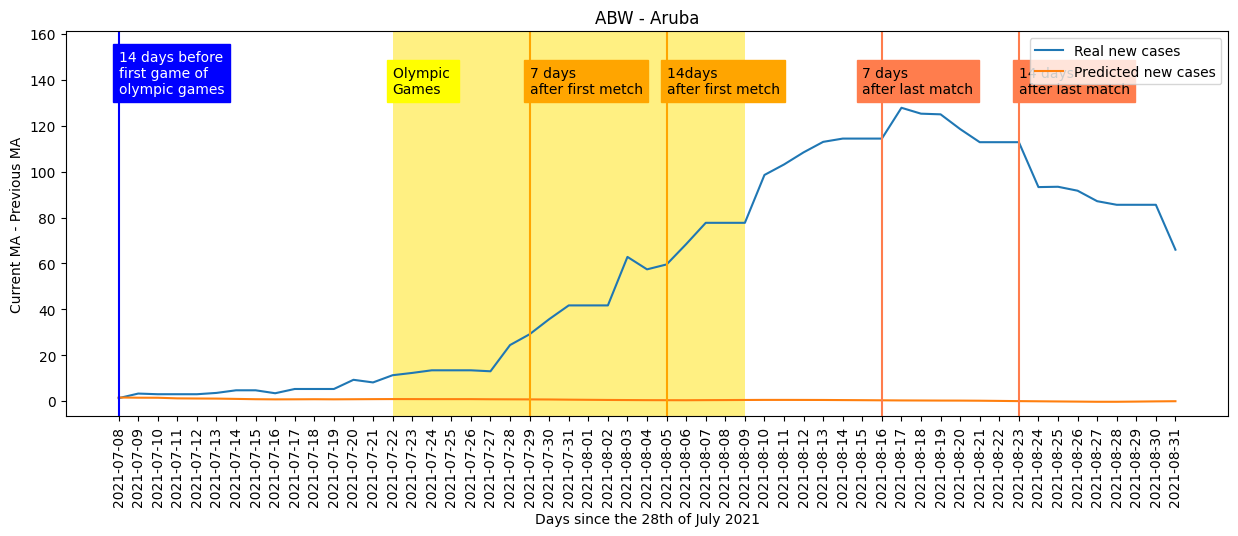

2021-03-01
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1617.287, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2026.971, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=2026.435, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=1617.412, Time=0.67 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=1608.679, Time=0.53 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=1402.523, Time=0.69 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=1404.199, Time=0.83 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1406.344, Time=0.34 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC

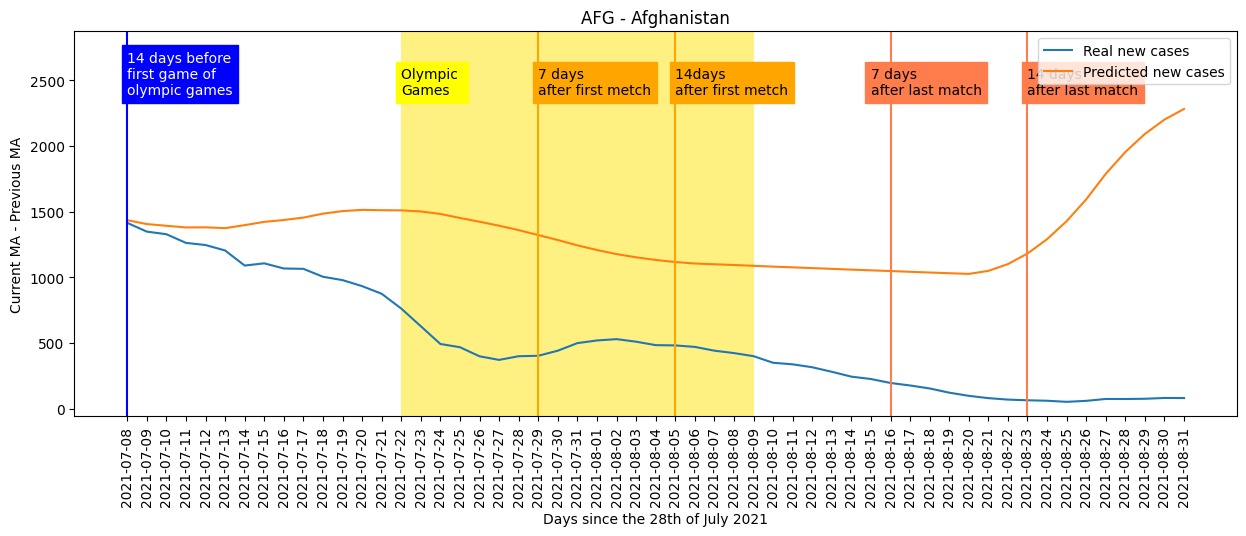

2021-03-08
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1117.696, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1414.884, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=883.271, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1893.231, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=882.837, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=883.769, Time=0.79 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=877.964, Time=0.57 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=873.812, Time=0.47 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=875.154, Time=0.58 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=873.945, Time=1.04 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=872.472, Time=0.49 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=876.657, Time=0.19 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=1103.198, Time=0.44 sec
 ARIMA(2,0,0)(1,0,2)[4] i

KeyboardInterrupt: 

In [26]:
tabella = pd.DataFrame(columns=['State','First_vaccine_date','Full','Before','first_week','first_second_week','before_last_game','second_seven_week','second_second_week','After','RMSE'])
split_date = date(2021, 7, 7)
rmses_mean = 0
counter = 0

before_trend_positive = []
before_trend_negative = []
first_week_trend_positive = []
first_week_trend_negative = []
first_second_week_trend_positive = []
first_second_week_trend_negative = []
before_last_game_trend_positive = []
before_last_game_trend_negative = []
second_week_trend_positive = []
second_week_trend_negative = []
second_second_week_trend_positive = []
second_second_week_trend_negative = []
after_trend_positive = []
after_trend_negative = []

#print(iso_code_list)

for code in iso_code_list:
    try:
        # STEP 1: crea un df con solo data e valore per ogni stato
        df_cases = pd.DataFrame(df_new_cases.loc[code]['moving_average_new_cases'].values, index = df_new_cases.loc[code]['moving_average_new_cases'].index, columns = ['moving_average_new_cases'])
        df_vaccin = pd.DataFrame(df_vaccination.loc[code]['moving_average_new_vaccinations'].values, index = df_vaccination.loc[code]['moving_average_new_vaccinations'].index, columns = ['moving_average_new_vaccinations'])
        
        # STEP 2: mergia i due df in uno solo
        merged_df = df_cases.merge(df_vaccin, on=['date'])
        merged_df.to_csv(f"./out/ARIMA/tmp/merged_df_{code}.csv")
        
        #find split date for df_vaccin that indicate first value not null of 0 for moving_average_new_vaccinations
        first_date = merged_df.loc[merged_df['moving_average_new_vaccinations'] > 0].index[0]
        last_date = str(split_date.strftime("%Y-%m-%d"))
        
        print(first_date)
        print(last_date)
        
        merged_df_train = merged_df.loc[(merged_df.index >= first_date) & (merged_df.index <= last_date)].copy()
        merged_df_test = merged_df.loc[merged_df.index > last_date].copy()
        
        merged_df_train.to_csv(f"./out/ARIMA/tmp/merged_df_train_{code}.csv")
        merged_df_test.to_csv(f"./out/ARIMA/tmp/merged_df_test_{code}.csv")
        
        #print(merged_df_train)
        #print(merged_df_test)
        
        best_model, best_pred, best_d, min_rmse = train_model(merged_df_train, merged_df_test)
        
        # STEP 4: crea un modello auto_ARIMA per predirre i new_cases considerando i vaccini fino 2 settimane prima dell'inizio delle olimpiadi
        model = pm.auto_arima(merged_df_train['moving_average_new_cases'], X=merged_df_train[["moving_average_new_vaccinations"]], start_p=0, start_q=0,
                                    test='adf',       # use adftest to find optimal 'd'
                                    max_p=3, max_q=3, # maximum p and q
                                    d=best_d,          # let model determine 'd'
                                    m=4,              # frequency of series
                                    error_action='ignore',
                                    stagionality=True,
                                    suppress_warnings=True,
                                    random_state=42,
                                    maxiter=500, stationary=False,
                                    trace=True,)
        
        length = len(merged_df_test)
        pred, ci = model.predict(n_periods=length, X=merged_df_test[["moving_average_new_vaccinations"]], alpha=0.05, return_conf_int=True)
        '''print("------------------")
        print(pred)
        print("------------------")'''
        
        print(len(merged_df_test))
        
        
        #STEP 5: dividi il test set in 3 parti: 14 giorni prima, durante le olimpiadi e 14 giorni dopo    
        before_olympic = merged_df_test.loc[merged_df_test.index <= str(split_date + timedelta(days=21))].copy()
        first_seven_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=21))) & (merged_df_test.index <= str(split_date + timedelta(days=28)))].copy()
        first_second_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=28))) & (merged_df_test.index <= str(split_date + timedelta(days=35)))].copy()
        before_last_game = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=35))) & (merged_df_test.index <= str(split_date + timedelta(days=39)))].copy()
        second_seven_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=39))) & (merged_df_test.index <= str(split_date + timedelta(days=46)))].copy()
        second_second_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=46))) & (merged_df_test.index <= str(split_date + timedelta(days=53)))].copy()
        after_olympic = merged_df_test.loc[merged_df_test.index > str(split_date + timedelta(days=53))].copy()
        
        #STEP 6: predici i new_cases
        full_olympic_predicted = model.predict(n_periods=len(merged_df_test), X=merged_df_test[["moving_average_new_vaccinations"]])
        
        # STEP 6.1: sementa la previsione 
        before_olympic_predicted = full_olympic_predicted[:21]
        first_seven_week__predicted = full_olympic_predicted[21:28]
        first_second_week_predicted = full_olympic_predicted[28:35]
        before_last_game_prediction = full_olympic_predicted[35:39]
        second_seven_week_predicted = full_olympic_predicted[39:46]
        second_second_week_predicted = full_olympic_predicted[46:53]
        after_olympic_predicted = full_olympic_predicted[53:]
        
        #STEP 7: calcola la media dei new_cases predetti per ogni parte del test set
        full_olympic_mean_predicted = full_olympic_predicted.mean()
        before_olympic_mean_predicted = full_olympic_predicted[:21].mean()
        first_seven_week_mean_predicted = full_olympic_predicted[21:28].mean()
        first_second_week_mean_predicted = full_olympic_predicted[28:35].mean()
        before_last_game_mean_predicted = full_olympic_predicted[35:39].mean()
        second_seven_week_mean_predicted = full_olympic_predicted[39:46].mean()
        second_second_week_mean_predicted = full_olympic_predicted[46:53].mean()
        after_olympic_mean_predicted = full_olympic_predicted[53:].mean()
        
        #STEP 8: calcola la differenza tra la media dei new_cases predetti e la media dei new_cases reali
        full_olympic_difference = full_olympic_mean_predicted - merged_df_test['moving_average_new_cases'].mean()
        before_olympic_difference = before_olympic_mean_predicted - before_olympic['moving_average_new_cases'].mean()
        first_seven_week_difference = first_seven_week_mean_predicted - first_seven_week['moving_average_new_cases'].mean()
        first_second_week_difference = first_second_week_mean_predicted - first_second_week['moving_average_new_cases'].mean()
        before_last_game_difference = before_last_game_mean_predicted - before_last_game['moving_average_new_cases'].mean()
        second_seven_week_difference = second_seven_week_mean_predicted - second_seven_week['moving_average_new_cases'].mean()
        second_second_week_difference = second_second_week_mean_predicted - second_second_week['moving_average_new_cases'].mean()
        after_olympic_difference = after_olympic_mean_predicted - after_olympic['moving_average_new_cases'].mean()
        
        #STEP 9: calcola la percentuale di differenza tra la media dei new_cases predetti e la media dei new_cases reali
        full_olympic_percentage_difference = (full_olympic_difference/merged_df_test['moving_average_new_cases'].mean())*100
        before_olympic_percentage_difference = (before_olympic_difference/before_olympic['moving_average_new_cases'].mean())*100
        first_seven_week_percentage_difference = (first_seven_week_difference/first_seven_week['moving_average_new_cases'].mean())*100
        first_second_week_percentage_difference = (first_second_week_difference/first_second_week['moving_average_new_cases'].mean())*100
        before_last_game_percentage_difference = (before_last_game_difference/before_last_game['moving_average_new_cases'].mean())*100
        second_seven_week_percentage_difference = (second_seven_week_difference/second_seven_week['moving_average_new_cases'].mean())*100
        second_second_week_percentage_difference = (second_second_week_difference/second_second_week['moving_average_new_cases'].mean())*100
        after_olympic_percentage_difference = (after_olympic_difference/after_olympic['moving_average_new_cases'].mean())*100
        
        #STEP 10: clacola rmse
        rmse = math.sqrt(mean_squared_error(merged_df_test['moving_average_new_cases'], full_olympic_predicted))
        rmse_mean += rmse
        counter += 1
        
        
        #STEP 11: aggiungi il code al corrispettivo array se la differenza è positiva o negativa
        if before_olympic_percentage_difference > 0:
            before_trend_positive.append(code)
        else:
            before_trend_negative.append(code)
        if first_seven_week_percentage_difference > 0:
            first_week_trend_positive.append(code)
        else:
            first_week_trend_negative.append(code)
        if first_second_week_percentage_difference > 0:
            first_second_week_trend_positive.append(code)
        else:
            first_second_week_trend_negative.append(code)
        if before_last_game_percentage_difference > 0:
            before_last_game_trend_positive.append(code)
        else:
            before_last_game_trend_negative.append(code)
        if second_seven_week_percentage_difference > 0:
            second_week_trend_positive.append(code)
        else:
            second_week_trend_negative.append(code)
        if second_second_week_percentage_difference > 0:
            second_second_week_trend_positive.append(code)
        else:
            second_second_week_trend_negative.append(code)
        if after_olympic_percentage_difference > 0:
            after_trend_positive.append(code)
        else:
            after_trend_negative.append(code)
        
        #STEP 10: salva i risultati in un df
        row = pd.DataFrame.from_dict({'State': code,
                                      'First_vaccine_date': first_date,
                                      'Full': full_olympic_percentage_difference,
                                      'Before': before_olympic_percentage_difference,
                                      'first_week': first_seven_week_percentage_difference,
                                      'first_second_week': first_second_week_percentage_difference,
                                      'before_last_game': before_last_game_percentage_difference,
                                      'second_seven_week': second_seven_week_percentage_difference,
                                      'second_second_week': second_second_week_percentage_difference,
                                      'After': after_olympic_percentage_difference,
                                      'RMSE': rmse,
                                      }, orient='index').T
        tabella = pd.concat([tabella, row], ignore_index=True)
        
        #STEP 11: plot the results
        plt.figure(figsize=(15,5))
        plt.plot(merged_df_test.index, merged_df_test['moving_average_new_cases'], label = 'Real new cases')
        plt.plot(merged_df_test.index, full_olympic_predicted, label = 'Predicted new cases')
        plt.title(code + " - " + df_new_cases.loc[code]['Country'].unique()[0])
        plt.legend()
        
        ymax = plt.ylim()[1]
        plt.ylim(ymax=ymax*1.20)
        
        plt.text('2021-07-08', ymax, "14 days before\nfirst game of\nolympic games", rotation=0, color="white", backgroundcolor="blue")
        plt.text('2021-07-22', ymax, "Olympic \nGames", rotation=0, color="black", backgroundcolor="yellow")
        plt.text("2021-07-29", ymax, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
        plt.text("2021-08-05", ymax, "14days \nafter first metch", rotation=0, backgroundcolor="orange")
        plt.text('2021-08-15', ymax, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
        plt.text('2021-08-23', ymax, "14 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
        
        plt.axvline(x = '2021-07-08', color = 'blue', label = '14 days before first game of olympic games')
        plt.axvspan('2021-07-22', '2021-08-09', facecolor='#ffe206', alpha=0.5)
        plt.axvline(x = '2021-07-29', color = 'orange', label = '7 days after first game of olympic games')
        plt.axvline(x = '2021-08-05', color = 'orange', label = '14 days after first game of olympic games')
        plt.axvline(x = '2021-08-16', color = '#FF7D4D', label = '7 days after last game of olympic games')
        plt.axvline(x = '2021-08-23', color = '#FF7D4D', label = '14 days after last game of olympic games')
        
        plt.xlabel("Days since the 28th of July 2021")
        plt.xticks(rotation=90)
        plt.ylabel("Current MA - Previous MA")
        
        #save the plot as a png file
        plt.savefig("../pictures/"+ code + "_intervals" +".png")
        plt.savefig("./out/ARIMA/pictures/"+ code + "_intervals" +".png")
        plt.show()
    except:
        print("Error in " + code )

rmses_mean = rmses_mean/counter

In [ ]:
print("RMSE mean: " + str(rmses_mean))
print(tabella)

In [ ]:
#tabella is the table for changepoints and tabella2 is the table for the intervals
tabella.set_index(tabella['State'])
tabella.to_csv("./out/ARIMA/ARIMA_results.csv", index=False)